In [6]:
#install.packages('dslabs')
#install.packages('tidyverse')
#install.packages('purrr')
#install.packages('dplyr')
install.packages('ggplot2')

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [2]:
library(dslabs)
data('movielens')

In [3]:
head(movielens)

movieId,title,year,genres,userId,rating,timestamp
31,Dangerous Minds,1995,Drama,1,2.5,1260759144
1029,Dumbo,1941,Animation|Children|Drama|Musical,1,3.0,1260759179
1061,Sleepers,1996,Thriller,1,3.0,1260759182
1129,Escape from New York,1981,Action|Adventure|Sci-Fi|Thriller,1,2.0,1260759185
1172,Cinema Paradiso (Nuovo cinema Paradiso),1989,Drama,1,4.0,1260759205
1263,"Deer Hunter, The",1978,Drama|War,1,2.0,1260759151


In [8]:
library(purrr)
library(dplyr)
library(ggplot2)

movielens %>% summarize(n_users = n_distinct(userId),
                       n_movies = n_distinct(movieId))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



n_users,n_movies
671,9066


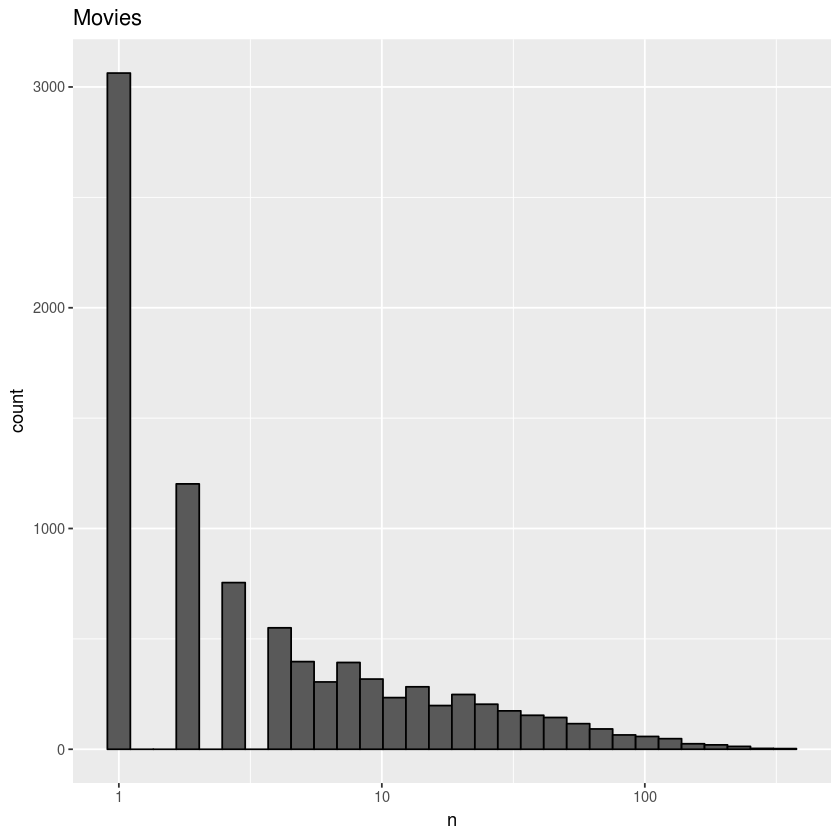

In [11]:
movielens %>% 
  count(movieId) %>% 
  ggplot(aes(n)) + 
  geom_histogram(bins = 30, color = "black") + 
  scale_x_log10() + 
  ggtitle("Movies")

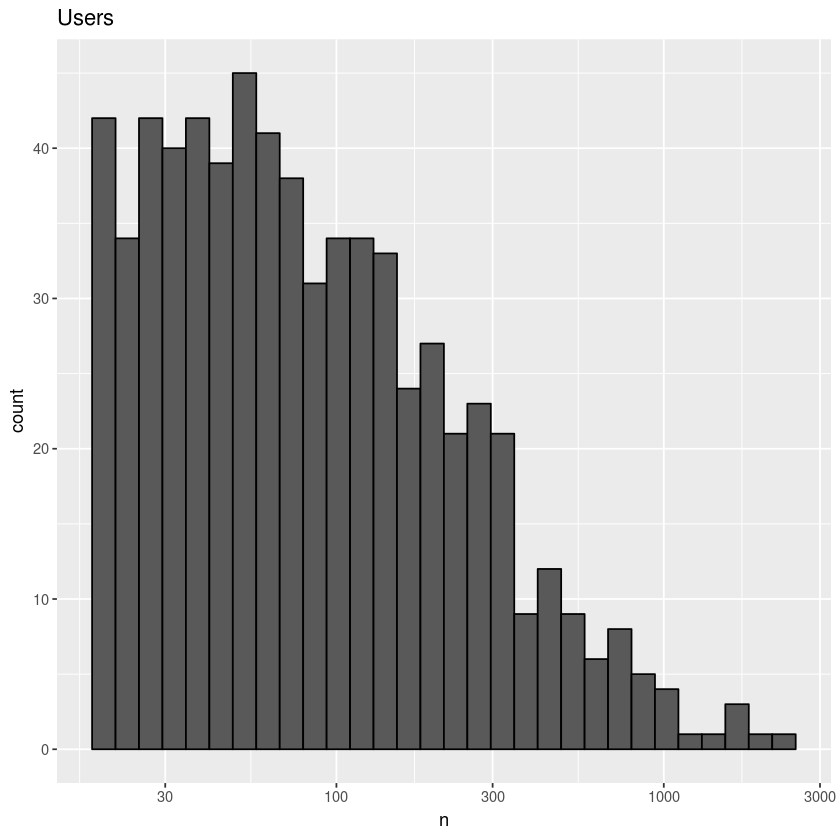

In [12]:
movielens %>% 
  count(userId) %>% 
  ggplot(aes(n)) + 
  geom_histogram(bins = 30, color = "black") + 
  scale_x_log10() + 
  ggtitle("Users")

In [9]:
install.packages('caret')

also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘generics’, ‘gower’, ‘ipred’, ‘RcppRoll’, ‘timeDate’, ‘recipes’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [13]:
library(caret)
set.seed(755)

test_index <- createDataPartition(y=movielens$rating, times=1,p=0.2,list=FALSE)

train_set <- movielens[-test_index,]
test_set <- movielens[test_index,]

test_set <- test_set %>% semi_join(train_set, by='movieId') %>% semi_join(train_set,by='userId')

In [14]:
RMSE <- function(true_ratings, predicted_ratings){
    sqrt(mean((true_ratings - predicted_ratings)^2))
}

In [16]:
mu_hat <- mean(train_set$rating)
mu_hat

[1] 3.542793

In [17]:
naive_rmse <- RMSE(test_set$rating, mu_hat)
naive_rmse

[1] 1.04822

In [18]:
rmse_results <- data_frame(method = 'Just the average', RMSE = naive_rmse)

In [ ]:
fit <- lm(rating ~ as.factor(userId), data=movielens)

In [20]:
mu <- mean(train_set$rating)
movie_avgs <- train_set %>% group_by(movieId) %>% summarize(b_i = mean(rating-mu))

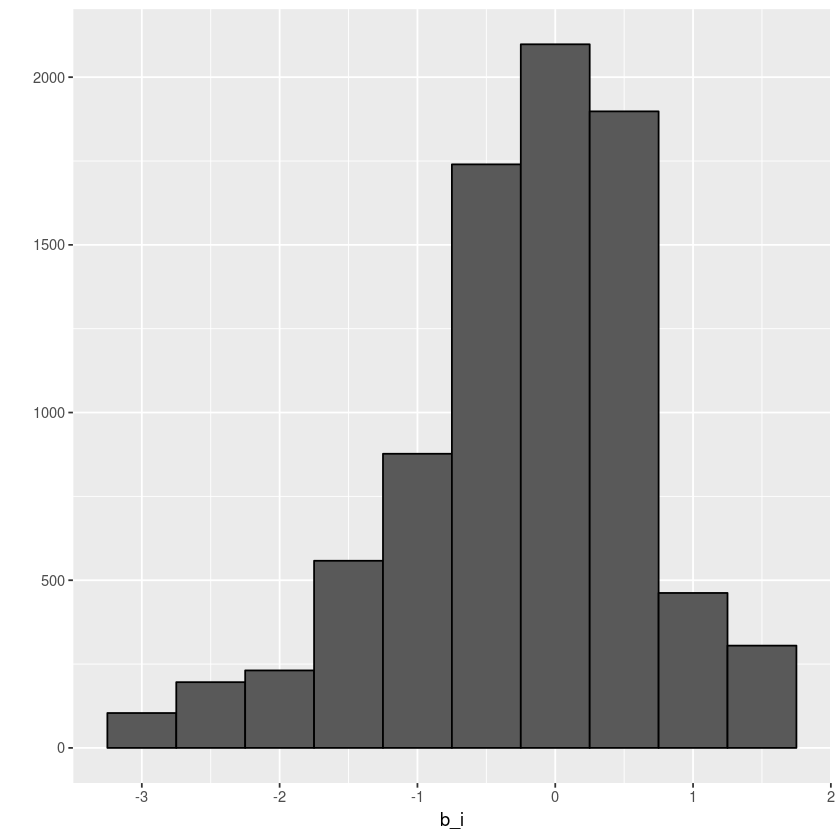

In [21]:
movie_avgs %>% qplot(b_i, geom ="histogram", bins = 10, data = ., color = I("black"))

In [25]:
predicted_ratings <- mu + test_set %>% 
  left_join(movie_avgs, by='movieId') %>%
  .$b_i

model_1_rmse <- RMSE(predicted_ratings, test_set$rating)
rmse_results <- bind_rows(rmse_results,
                          data_frame(method="Movie Effect Model",  
                                     RMSE = model_1_rmse ))
rmse_results %>% knitr::kable()



|method             |      RMSE|
|:------------------|---------:|
|Just the average   | 1.0482202|
|Movie Effect Model |       NaN|
|Movie Effect Model | 0.9862839|

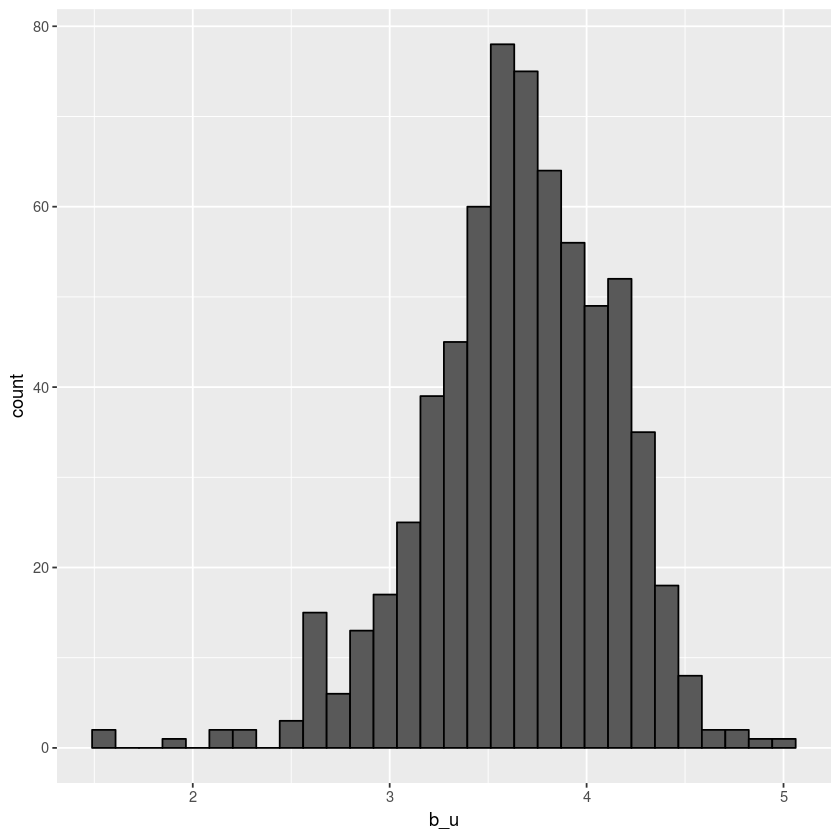

In [26]:
train_set %>% 
  group_by(userId) %>% 
  summarize(b_u = mean(rating)) %>% 
  filter(n()>=100) %>%
  ggplot(aes(b_u)) + 
  geom_histogram(bins = 30, color = "black")

In [ ]:
lm(rating ~ as.factor(movieId) + as.factor(userId))

In [27]:
user_avgs <- test_set %>% 
  left_join(movie_avgs, by='movieId') %>%
  group_by(userId) %>%
  summarize(b_u = mean(rating - mu - b_i))

In [28]:
predicted_ratings <- test_set %>% 
  left_join(movie_avgs, by='movieId') %>%
  left_join(user_avgs, by='userId') %>%
  mutate(pred = mu + b_i + b_u) %>%
  .$pred


model_2_rmse <- RMSE(predicted_ratings, test_set$rating)
rmse_results <- bind_rows(rmse_results,
                          data_frame(method="Movie + User Effects Model",  
                                     RMSE = model_2_rmse ))
rmse_results %>% knitr::kable()



|method                     |      RMSE|
|:--------------------------|---------:|
|Just the average           | 1.0482202|
|Movie Effect Model         |       NaN|
|Movie Effect Model         | 0.9862839|
|Movie + User Effects Model | 0.8848688|

In [31]:
test_set %>%
    left_join(movie_avgs, by='movieId') %>%
    mutate(residual = rating - (mu + b_i)) %>%
    arrange(desc(abs(residual))) %>%
    select(title, residual) %>% slice(1:10) %>% knitr::kable()



|title                                            |  residual|
|:------------------------------------------------|---------:|
|Day of the Beast, The (Día de la Bestia, El)     |  4.500000|
|Horror Express                                   | -4.000000|
|No Holds Barred                                  |  4.000000|
|Dear Zachary: A Letter to a Son About His Father | -4.000000|
|Faust                                            | -4.000000|
|Hear My Song                                     | -4.000000|
|Confessions of a Shopaholic                      | -4.000000|
|Twilight Saga: Breaking Dawn - Part 1, The       | -4.000000|
|Taxi Driver                                      | -3.806931|
|Taxi Driver                                      | -3.806931|

In [32]:
movie_titles <- movielens %>%
    select(movieId, title) %>%
    distinct()
movie_avgs %>% left_join(movie_titles, by='movieId') %>%
    arrange(desc(b_i)) %>%
    select(title, b_i) %>%
    slice(1:10) %>%
    knitr::kable()



|title                                                   |      b_i|
|:-------------------------------------------------------|--------:|
|Lamerica                                                | 1.457207|
|Love & Human Remains                                    | 1.457207|
|Enfer, L'                                               | 1.457207|
|Picture Bride (Bijo photo)                              | 1.457207|
|Red Firecracker, Green Firecracker (Pao Da Shuang Deng) | 1.457207|
|Faces                                                   | 1.457207|
|Maya Lin: A Strong Clear Vision                         | 1.457207|
|Heavy                                                   | 1.457207|
|Gate of Heavenly Peace, The                             | 1.457207|
|Death in the Garden (Mort en ce jardin, La)             | 1.457207|

In [33]:
train_set %>% count(movieId) %>%
    left_join(movie_avgs) %>%
    left_join(movie_titles, by='movieId') %>%
    arrange(desc(b_i)) %>%
    select(title, b_i, n) %>%
    slice(1:10) %>%
    knitr::kable()

Joining, by = "movieId"




|title                                                   |      b_i|  n|
|:-------------------------------------------------------|--------:|--:|
|Lamerica                                                | 1.457207|  1|
|Love & Human Remains                                    | 1.457207|  3|
|Enfer, L'                                               | 1.457207|  1|
|Picture Bride (Bijo photo)                              | 1.457207|  1|
|Red Firecracker, Green Firecracker (Pao Da Shuang Deng) | 1.457207|  3|
|Faces                                                   | 1.457207|  1|
|Maya Lin: A Strong Clear Vision                         | 1.457207|  2|
|Heavy                                                   | 1.457207|  1|
|Gate of Heavenly Peace, The                             | 1.457207|  1|
|Death in the Garden (Mort en ce jardin, La)             | 1.457207|  1|

In [36]:
lambda <- 3
mu <- mean(train_set$rating)
movie_reg_avgs <- train_set %>%
    group_by(movieId) %>%
    summarize(b_i = sum(rating - mu)/(n()+lambda), n_i = n())

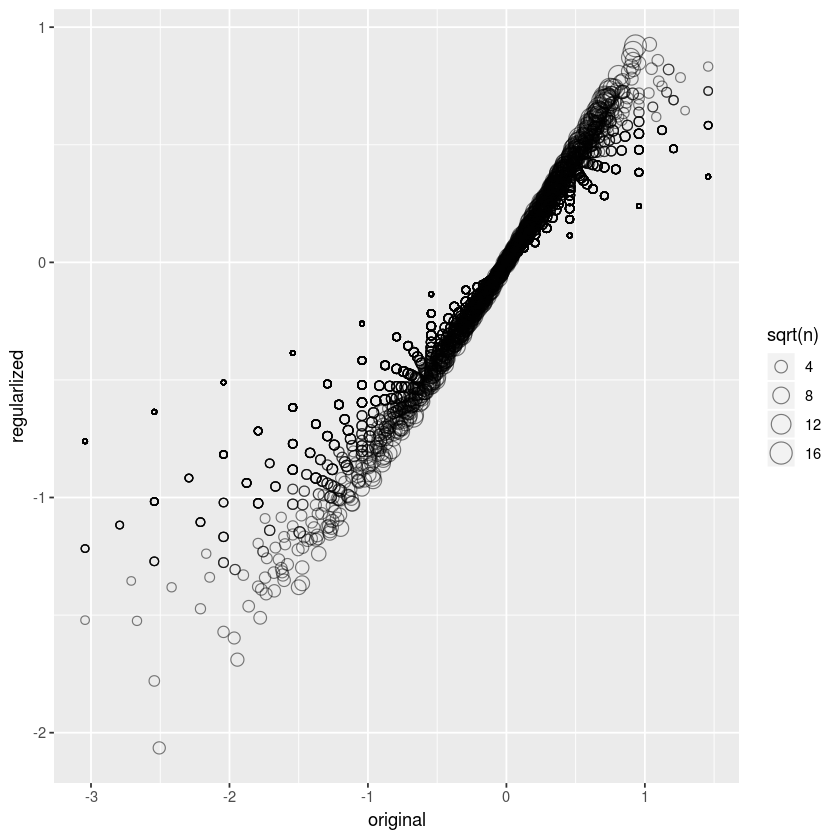

In [37]:
data_frame(original = movie_avgs$b_i, 
           regularlized = movie_reg_avgs$b_i, 
           n = movie_reg_avgs$n_i) %>%
    ggplot(aes(original, regularlized, size=sqrt(n))) + 
        geom_point(shape=1, alpha=0.5)

In [38]:
train_set %>%
  count(movieId) %>% 
  left_join(movie_reg_avgs) %>%
  left_join(movie_titles, by="movieId") %>%
  arrange(desc(b_i)) %>% 
  select(title, b_i, n) %>% 
  slice(1:10) %>% 
  knitr::kable()
#> Joining, by = "movieId"

Joining, by = "movieId"




|title                          |       b_i|   n|
|:------------------------------|---------:|---:|
|All About Eve                  | 0.9271514|  26|
|Shawshank Redemption, The      | 0.9206986| 240|
|Godfather, The                 | 0.8971328| 153|
|Godfather: Part II, The        | 0.8710751| 100|
|Maltese Falcon, The            | 0.8597749|  47|
|Best Years of Our Lives, The   | 0.8592343|  11|
|On the Waterfront              | 0.8467603|  23|
|Face in the Crowd, A           | 0.8326899|   4|
|African Queen, The             | 0.8322939|  36|
|All Quiet on the Western Front | 0.8235200|  11|

In [39]:
train_set %>%
  count(movieId) %>% 
  left_join(movie_reg_avgs) %>%
  left_join(movie_titles, by="movieId") %>%
  arrange(b_i) %>% 
  select(title, b_i, n) %>% 
  slice(1:10) %>% 
  knitr::kable()
#> Joining, by = "movieId"

Joining, by = "movieId"




|title                              |       b_i|  n|
|:----------------------------------|---------:|--:|
|Battlefield Earth                  | -2.064653| 14|
|Joe's Apartment                    | -1.779955|  7|
|Speed 2: Cruise Control            | -1.689385| 20|
|Super Mario Bros.                  | -1.597269| 13|
|Police Academy 6: City Under Siege | -1.571379| 10|
|After Earth                        | -1.524453|  4|
|Disaster Movie                     | -1.521396|  3|
|Little Nicky                       | -1.511374| 17|
|Cats & Dogs                        | -1.472973|  6|
|Blade: Trinity                     | -1.462194| 11|

In [40]:
predicted_ratings <- test_set %>% 
  left_join(movie_reg_avgs, by='movieId') %>%
  mutate(pred = mu + b_i) %>%
  .$pred

model_3_rmse <- RMSE(predicted_ratings, test_set$rating)
rmse_results <- bind_rows(rmse_results,
                          data_frame(method="Regularized Movie Effect Model",  
                                     RMSE = model_2_rmse ))
rmse_results %>% knitr::kable()



|method                         |      RMSE|
|:------------------------------|---------:|
|Just the average               | 1.0482202|
|Movie Effect Model             |       NaN|
|Movie Effect Model             | 0.9862839|
|Movie + User Effects Model     | 0.8848688|
|Regularized Movie Effect Model | 0.8848688|

[1] 3

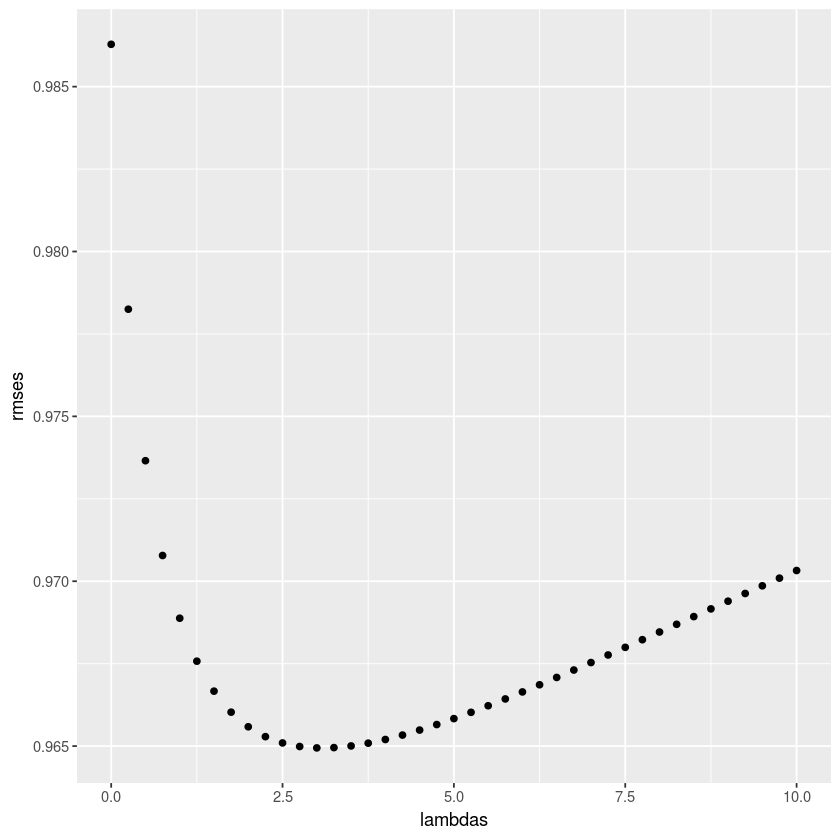

In [41]:
lambdas <- seq(0, 10, 0.25)

mu <- mean(train_set$rating)
just_the_sum <- train_set %>% 
  group_by(movieId) %>% 
  summarize(s = sum(rating - mu), n_i = n())

rmses <- sapply(lambdas, function(l){
  predicted_ratings <- test_set %>% 
    left_join(just_the_sum, by='movieId') %>% 
    mutate(b_i = s/(n_i+l)) %>%
    mutate(pred = mu + b_i) %>%
    .$pred
  return(RMSE(predicted_ratings, test_set$rating))
})
qplot(lambdas, rmses)  
lambdas[which.min(rmses)]
#> [1] 3

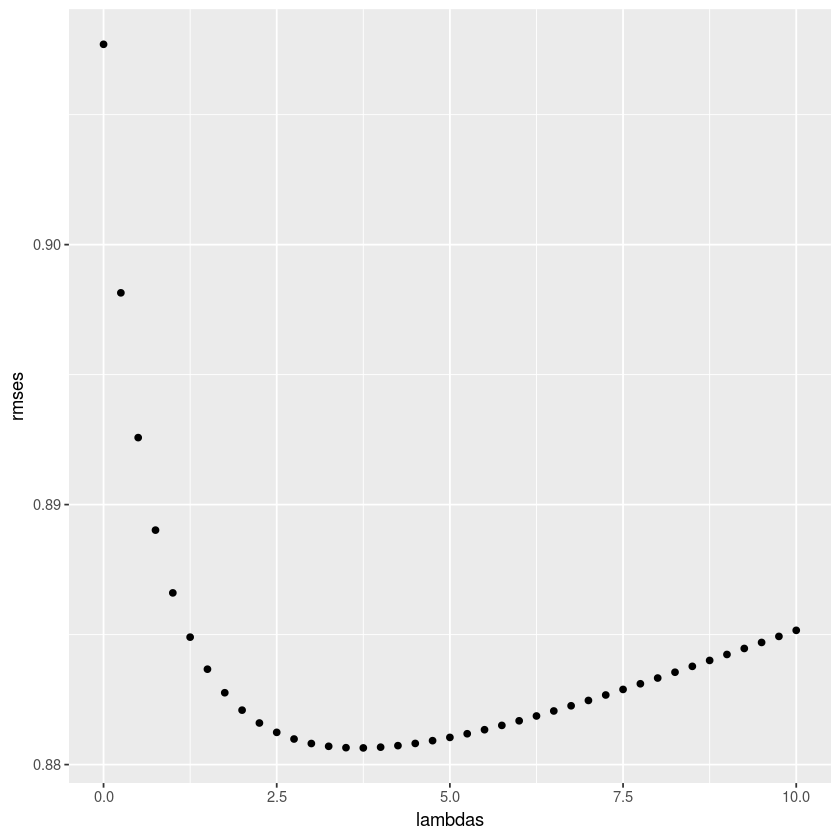

In [42]:
rmses <- sapply(lambdas, function(l){

  mu <- mean(train_set$rating)
  
  b_i <- train_set %>% 
    group_by(movieId) %>%
    summarize(b_i = sum(rating - mu)/(n()+l))
  
  b_u <- train_set %>% 
    left_join(b_i, by="movieId") %>%
    group_by(userId) %>%
    summarize(b_u = sum(rating - b_i - mu)/(n()+l))

  predicted_ratings <- 
    test_set %>% 
    left_join(b_i, by = "movieId") %>%
    left_join(b_u, by = "userId") %>%
    mutate(pred = mu + b_i + b_u) %>%
    .$pred
  
    return(RMSE(predicted_ratings, test_set$rating))
})

qplot(lambdas, rmses)  

In [43]:
lambda <- lambdas[which.min(rmses)]
lambda

[1] 3.75

In [44]:
rmse_results <- bind_rows(rmse_results,
                          data_frame(method="Regularized Movie + User Effect Model",  
                                     RMSE = min(rmses)))
rmse_results %>% knitr::kable()



|method                                |      RMSE|
|:-------------------------------------|---------:|
|Just the average                      | 1.0482202|
|Movie Effect Model                    |       NaN|
|Movie Effect Model                    | 0.9862839|
|Movie + User Effects Model            | 0.8848688|
|Regularized Movie Effect Model        | 0.8848688|
|Regularized Movie + User Effect Model | 0.8806419|